#### Objectives

1. P-Cygni line formation.
2. Analysing a P-Cygni line.
3. Running TARDIS to model a Type Ia supernova.


The characteristic P-Cygni profile of a supernova is formed by the ejecta moving.
![](pcygni_form1.jpg)

Consider an intensity ray coming off of the photo-
sphere. Solving the radiation transport problem in this case in
simple, since the ejecta properties are assumed to be constant
over the resonance region. The intensity after passing through
a line resonance region is simply

$$ I = I_{ph}e^{-\tau_{sob}} + S_{\lambda}(1 - e^{-\tau_{sob}})$$


where $\tau_{sob}$ is the sobolev optical depth and $S_{\lambda, \vec{r}}$ is the line source function at the resonance region $\vec{r}$. 

The first term describes the attenuation of the photospheric intensity and the second term is the light emitted from the line. 

A full solution of $S_{\lambda}$ requires a solution of the rate equations in statistical equilibrium. 

But edge cases can be possible -

For a purely absorptive line -

$$ S_{\lambda}(r) = B_{\lambda} (T, r)$$ 
at that specific temperature.

#### Calculate your synthetic supernova line ####

We have to integrate the specific intensity over the ejecta. 
We can think of a plane perpendicular to the line of sight of the observer. See the figure below.

Consider a ray with intensity I at the observed frame wavelength $\lambda_{obs}$ directed towards the observer parallel to the $z$-axis. The ray will come in resonance with the line at 

$$ z = \frac{\lambda_{obs} - \lambda_{0}}{\lambda_{0}} ct $$

After passing through the ejecta, the intensity that is observed will be -

$$ I(x, y, \lambda_{obs}) = I_{p}e^{-\tau} + S(1 - e^{-\tau})~[p \lt R_{ph}, r > R_{ph}, z \lt 0] \ $$
$$ I(x, y, \lambda_{obs}) = I_{p}~[ p \lt R_{ph}, z > 0] \ $$
$$ I(x, y, \lambda_{obs}) = I_{p}~[ r < R_{ph}] $$
$$ I(x, y, \lambda_{obs}) = S(1 - e^{-\tau})~[p \gt R_{ph}] $$ 

where, $p$ is the impact parameter $$ p = \sqrt(x^{2} + y^{2})$$.
The source function and the Sobolev optical depth ($\tau_{sob}$) is evaluated at coordinates (x, y, $\rm z_{res}$)



the impact parameter is as given in Jerkstrand 2017 
![](Pcygni_jerkstrand.png)

I have placed the observer at -ve z-axis, so the observer is looking at the +ve z-axis.

We now generate the spectra by integrating over the 2D space in either spherical or cylindrical coordinates.

$$ L_{\lambda} = \int \int I(x, y) dx dy = \int \int I(p, \phi) p dp d\phi $$

We will now simulate a P-Cygni line -


Ingredients

1. source function -
For a source function that emits an intensity $I_{ph}$ isotropically in all directions, the source function at a distance $r$ from the centre is -

$$ S = W(r)I$$ 
where W(r) is the geometric dilution factor.

$$W(r) = \frac{1}{2}[ 1 - \sqrt(1 - \frac{R_{ph}^{2}}{R^{2}})]$$


Use an optical depth of the form -

$$ \tau = \tau_{0} (\frac{v}{v_{ph}})^{-n} $$

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u

%config InlineBackend.figure_format = 'retina'

In [37]:
## wavelength grid (in angstroms)
wave_start  = 4300   # starting wavelength of spectrum
wave_stop   = 5500    # ending wavelength of spectrum
wave_bin    = 10      # spectral bin size

## photospheric properties
v_phot  = 10000.0  # velocity of the photosphere
T_ph    = 10000.0   # temperature of the photosphere

## line properties
lambda_0 = 5000.0  # rest wavelength of the line (in angstroms)
## spatial grid
n_x     = 80       # number of zones in the x-direction
v_max   = 30000.0  # velocity edge of the grid, in km/s

In [38]:

# physical constants
c_light_kms   = const.c.to(u.km/u.s).value
c_light_cgs  = const.c.to(u.cm/u.s).value
h_planck      = const.h.to(u.erg * u.s).value
k_boltz       = const.k_B.to(u.erg/u.K).value

In [39]:
def blackbody_lambda(wave, T):
    """
    Calculate the blackbody spectrum at a given temperature T
    for a given wavelength grid.

    Parameters
    ----------
    wave : array-like
        Wavelength grid in cms.
    T : float
        Temperature in Kelvin.
    Returns
    -------
    bb : array-like
        Blackbody spectrum in erg/s/cm^2/Hz.

    Notes
    -----
    const = 2hc^2/lambda^5
    bb = const/(exp(hc/lambda kT) - 1)
    where h is Planck's constant, c is the speed of light,
    k is Boltzmann's constant, and lambda is the wavelength.
    """
    cons = 2.0*h_planck*c_light_cgs**2.0/(wave)**5.0
    bb = cons/(np.exp(h_planck*c_light_cgs/wave/k_boltz/T) - 1)
    return bb

In [40]:
lambda_grid   = np.arange(wave_start, wave_stop, wave_bin)
spatial_grid  = np.arange(-1*v_max, v_max, 2*v_max/n_x)

def P_Cygni(v_phot, T_ph, tau_0, n):

	"""
	Calculate the P-Cygni profile for a given set of parameters.
	Parameters
	----------
	v_phot : float
		Velocity of the photosphere in km/s.
	T_ph : float
		Temperature of the photosphere in Kelvin.
	tau_0 : float
		Sobolev optical depth at the photosphere.
	n : int
		Power-index of the density profile.
	Returns
	-------
	L_observed : array-like
		Observed intensity at each wavelength.
	"""
	L_observed = np.zeros(len(lambda_grid))
	i = 0
	for lam in lambda_grid:

		# z coordinate - direction to the observer is in the -ve z-direction
		# See equation above 
		vz = (lam-lambda_0)/lambda_0*c_light_kms

		# set photospheric intensity to a blackbody
		lam_cm = lam*1e-8
		I_ph = blackbody_lambda(lam_cm, T_ph)

		# loop over x and y dimensions to integrate
		for vx in spatial_grid:
			for vy in spatial_grid:

				# radius at this point
				vr = (vx*vx + vy*vy + vz*vz)**0.5
				# impact parameter at this point
				vp = (vx*vx + vy*vy)**0.5

				# uses a simple power-law for now
				if (vr < v_phot): 
					etau = 1
				else:
					tau = tau_0*(vr/v_phot)**(-n)
					etau = np.exp(-1.0*tau)

				# get the line source function at this point
				# uses simple pure scattering for now
				if (vr < v_phot): 
					S = 0
				else:
					S  = I_ph*0.5*(1 - (1 - (v_phot/vr)**2.0)**0.5)	

				# calculate intensity from this ray
				I_ray = 0

				# position is inside the photosphere
				# we just see the photospheric intensity
				if (vr < v_phot):
					I_ray = I_ph

				# position is behind the photosphere
				# we just see the photospheric intensity
				elif (vp < v_phot and vz > 0): 
					I_ray = I_ph

				# position is in front of the photosphere
				# add in attenuated I_ph plus line emission
				elif (vp < v_phot):
					I_ray	= I_ph*etau + S*(1-etau)
	
				# this region is to the side of the photosphere
				#  there will be net emission
				else:
					I_ray += S*(1 - etau)

				# add in this intensity ray
				L_observed[i] += I_ray
	
		i += 1

	return L_observed

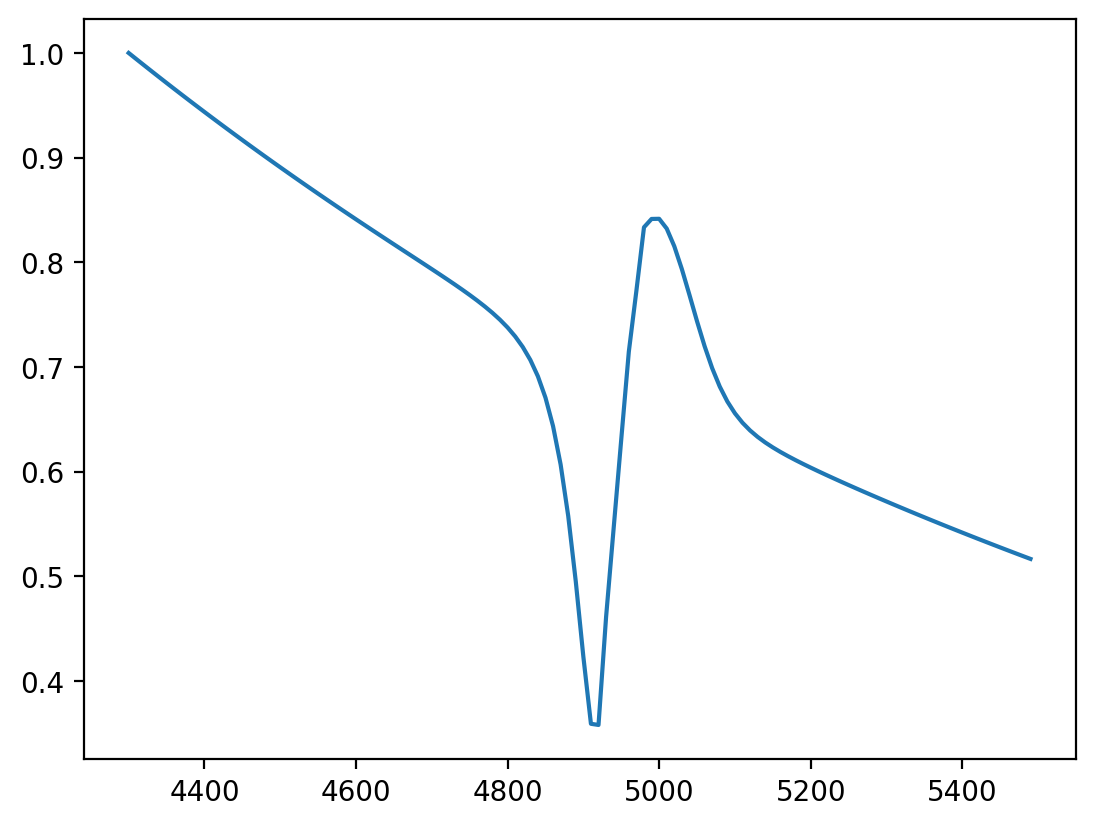

In [41]:
v_p = 5000     # km/s
T_p = 15000     # K
tau_0 = 5.0
n = 6.0
L = P_Cygni(v_p, T_p, tau_0, n)
# Normalising the spectrum
L_ = L / np.max(L)
plt.plot(lambda_grid, L_)

1. Can you change the photospheric velocity and see its effect?

Write your explanation

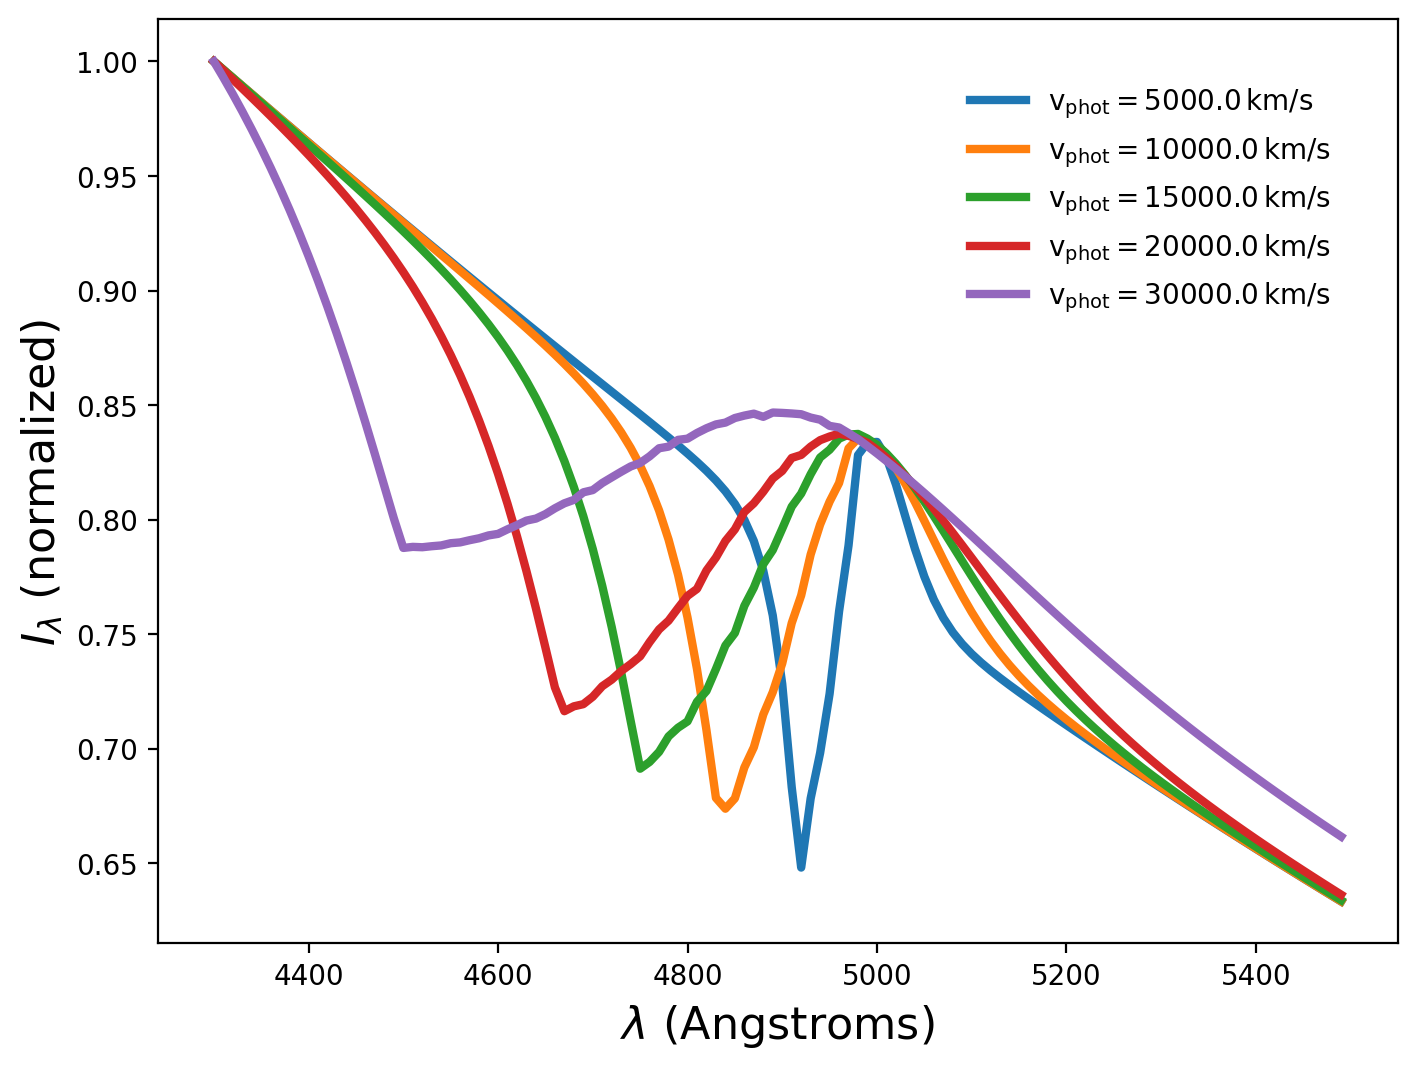

In [ ]:
v_p = [5000, 10000, 15000, 20000, 30000]
T_p = 10000
tau_0 = 1.0
n = 7.0

fig, axs = plt.subplots(figsize=(8, 6))

for j in range(len(v_p)):
    
    L = P_Cygni(v_p[j], T_p, tau_0, n)
    L_ = L / np.max(L)
    axs.plot(lambda_grid, L_, lw=3.0, label=r'$\rm v_{phot}=%.1f\, km/s$'%v_p[j])

axs.legend(loc="best", fontsize=10, fancybox=False, frameon=False, borderaxespad=2.0)
axs.set_xlabel(r'$\lambda$ (Angstroms)', fontsize=16)
axs.set_ylabel(r'$I_\lambda$ (normalized)', fontsize=16)

plt.show()


2. Change the photospheric temperature to see its effect 

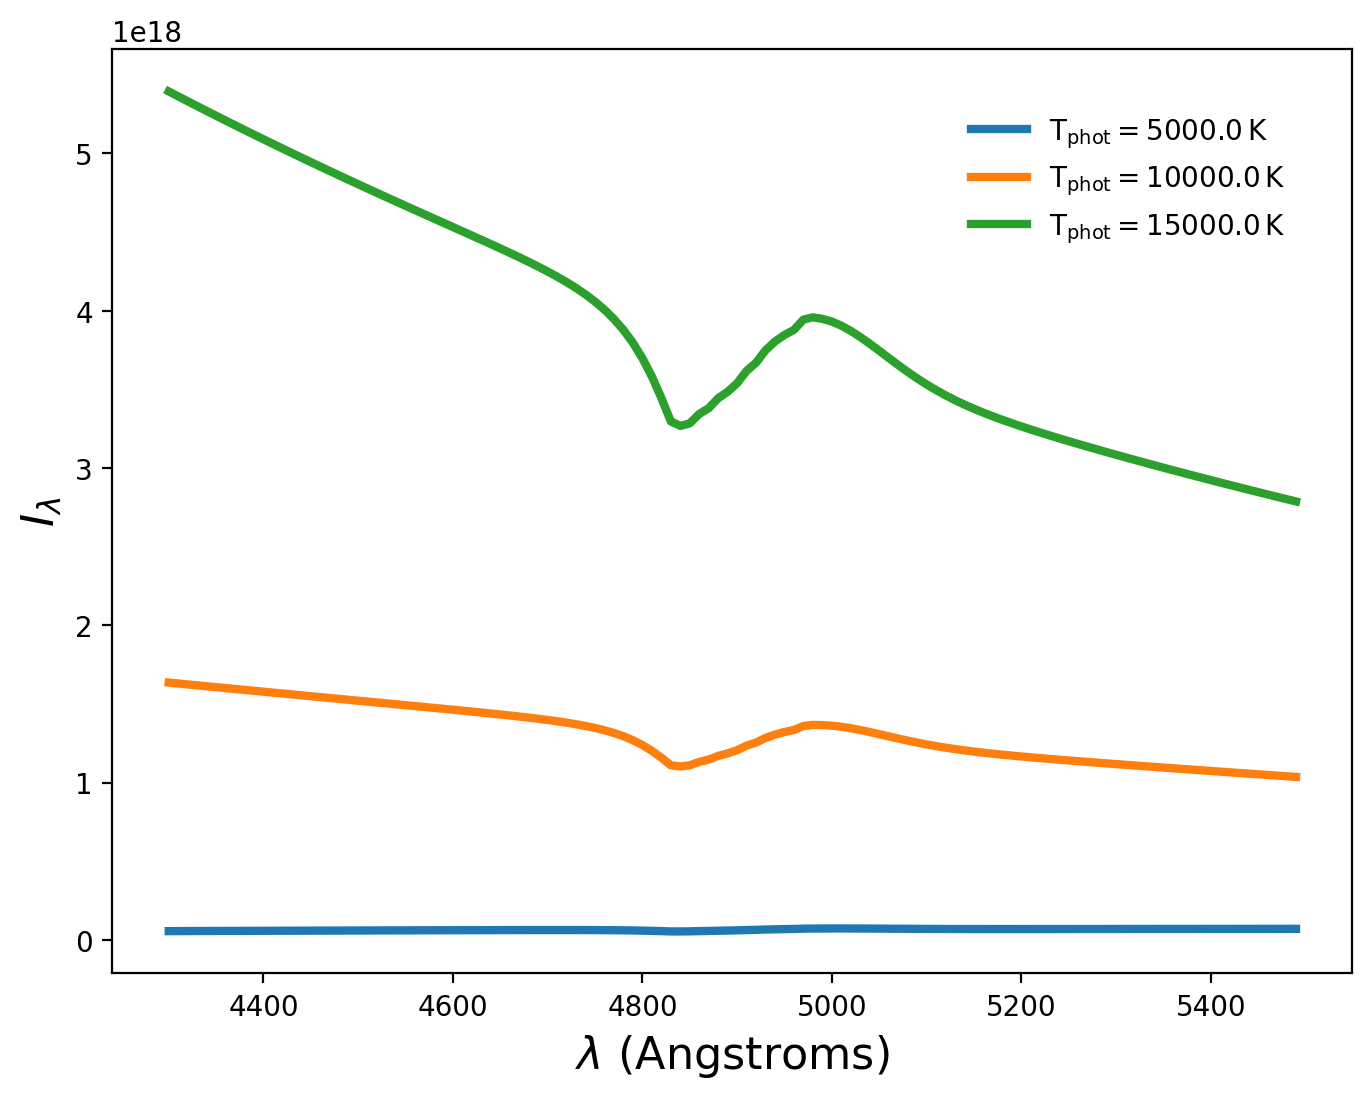

In [43]:
v_p = 10000
T_p = [5000, 10000, 15000]
tau_0 = 1.0
n = 7.0

fig, axs = plt.subplots(figsize=(8, 6))

for j in range(len(T_p)):

    L = P_Cygni(v_p, T_p[j], tau_0, n)
    # Do not normalise the spectrum. the continuum shape is due to a blackbody
    #L_ = L / np.max(L)
    axs.plot(lambda_grid, L, lw=3.0, label=r'$\rm T_{phot}=%.1f\, K$'%T_p[j])

axs.legend(loc="best", fontsize=10, fancybox=False, frameon=False, borderaxespad=2.0)
axs.set_xlabel(r'$\lambda$ (Angstroms)', fontsize=16)
axs.set_ylabel(r'$I_\lambda$', fontsize=16)

plt.show()

3. Change the power law index and see their effect 

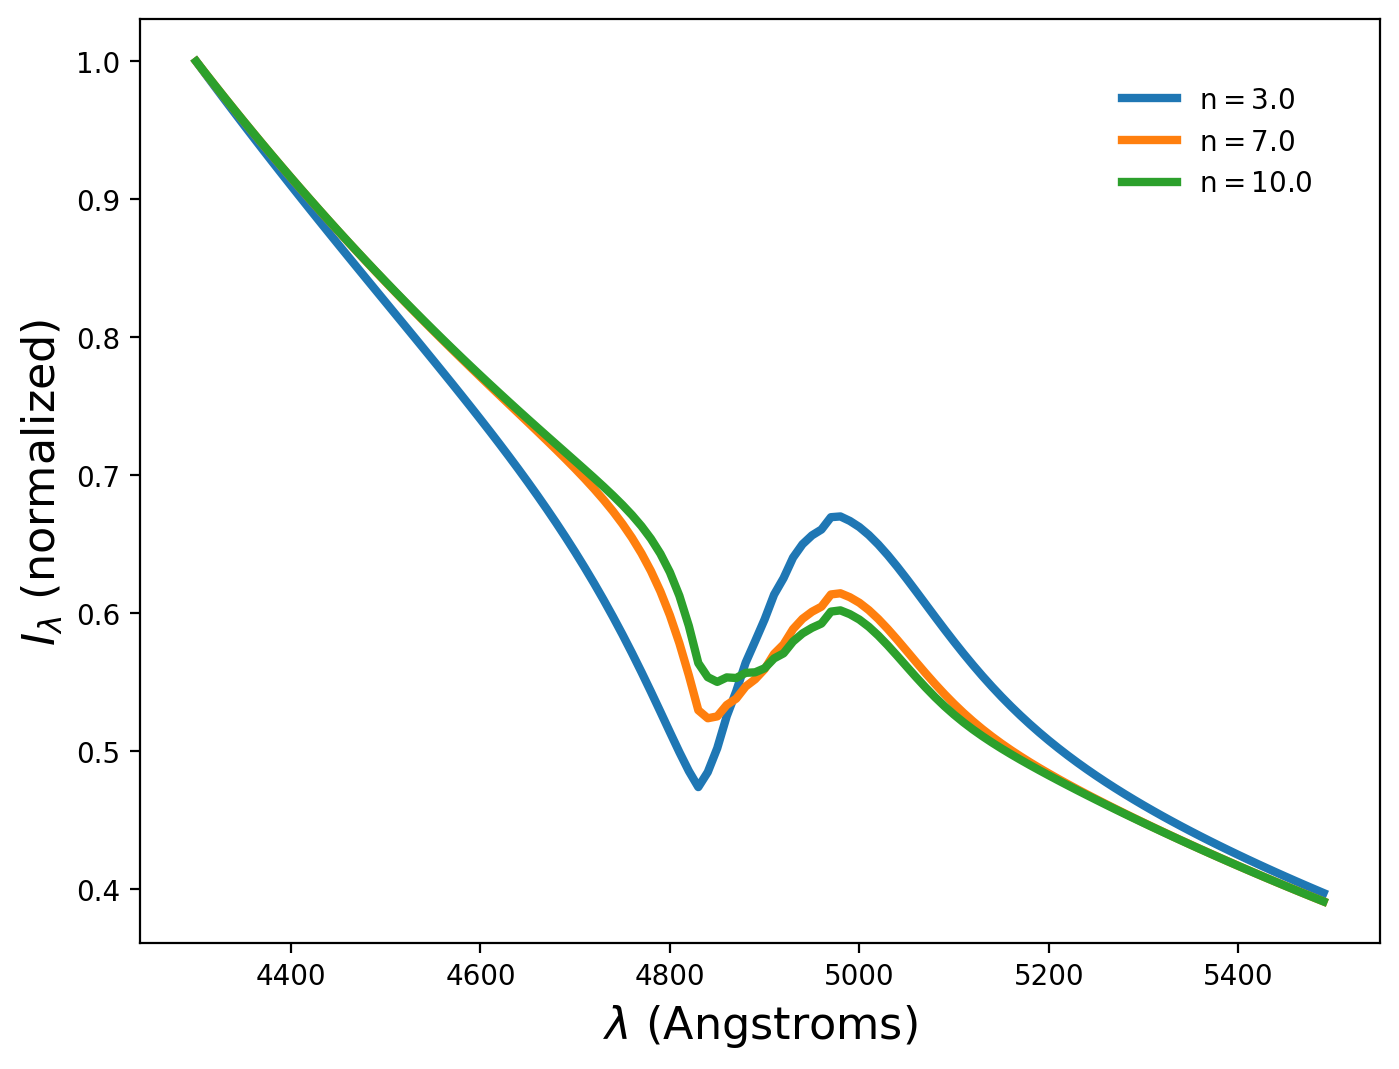

In [46]:
v_p = 10000
T_p = 100000
tau_0 = 1.0
n = [3, 7, 10]

fig, axs = plt.subplots(figsize=(8, 6))

for j in range(len(n)):

    L = P_Cygni(v_p, T_p, tau_0, n[j])
    # Do not normalise the spectrum. the continuum shape is due to a blackbody
    L_ = L / np.max(L)
    axs.plot(lambda_grid, L_, lw=3.0, label=r'$\rm n=%.1f\, $'%n[j])

axs.legend(loc="best", fontsize=10, fancybox=False, frameon=False, borderaxespad=2.0)
axs.set_xlabel(r'$\lambda$ (Angstroms)', fontsize=16)
axs.set_ylabel(r'$I_\lambda$ (normalized)', fontsize=16)

plt.show()

Why does a lower $n$ leads to a broad profile?

4. Change the optical depth $\tau_{0}$ 


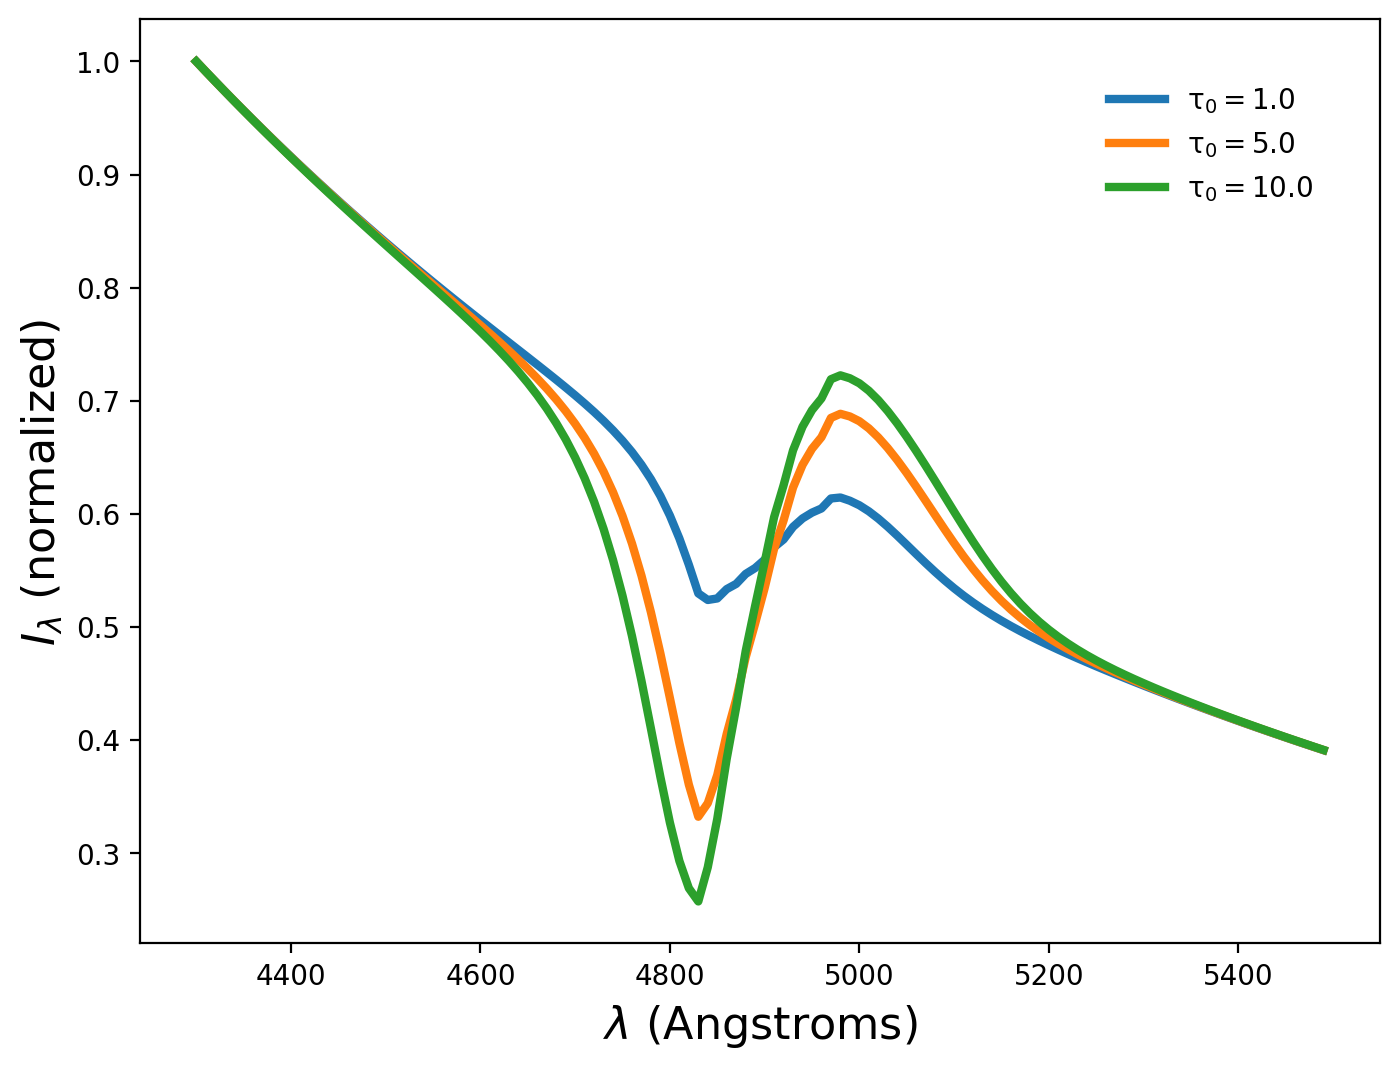

In [47]:
v_p = 10000
T_p = 100000
tau_0 = [1.0, 5.0, 10.0]
n = 7.0

fig, axs = plt.subplots(figsize=(8, 6))

for j in range(len(tau_0)):

    L = P_Cygni(v_p, T_p, tau_0[j], n)
    # Do not normalise the spectrum. the continuum shape is due to a blackbody
    L_ = L / np.max(L)
    axs.plot(lambda_grid, L_, lw=3.0, label=r'$\rm \tau_0=%.1f\, $'%tau_0[j])

axs.legend(loc="best", fontsize=10, fancybox=False, frameon=False, borderaxespad=2.0)
axs.set_xlabel(r'$\lambda$ (Angstroms)', fontsize=16)
axs.set_ylabel(r'$I_\lambda$ (normalized)', fontsize=16)

plt.show()

Explain the effect of $\tau$ on the spectrum

# A quickstart to TARDIS

# Installation instructions for tardis
wget -q https://raw.githubusercontent.com/tardis-sn/tardis/master/conda-{platform}-64.lock

Here {platform} can be osx / linux
#### Download the lock file
conda create --name tardis --file conda-{platform}-64.lock \
conda activate tardis

#### git clone git@github.com:username/tardis.git

cd tardis

pip install -e .

See more here https://tardis-sn.github.io/tardis/installation.html

If you do not have conda installed, then please try to install miniforge from here https://github.com/conda-forge/miniforge

then run the above commands with conda with mamba 

The documentation for TARDIS can be found at -

https://tardis-sn.github.io/tardis/

In [ ]:
#from tardis.io.atom_data import download_atom_data

In [ ]:
#download_atom_data('kurucz_cd23_chianti_H_He')

#### Download the TARDIS yml file

In [ ]:
!wget -q -nc https://raw.githubusercontent.com/tardis-sn/tardis/master/docs/tardis_example.yml

In [48]:
!cat tardis_example.yml

# Example YAML configuration for TARDIS
tardis_config_version: v1.0

supernova:
  luminosity_requested: 9.44 log_lsun
  time_explosion: 13 day

atom_data: kurucz_cd23_chianti_H_He.h5

model:
  structure:
    type: specific
    velocity:
      start: 1.1e4 km/s
      stop: 20000 km/s
      num: 20
    density:
      type: branch85_w7

  abundances:
    type: uniform
    O: 0.19
    Mg: 0.03
    Si: 0.52
    C: 0.04
    S: 0.19
    Ca: 0.03

plasma:
  disable_electron_scattering: no
  ionization: lte
  excitation: lte
  radiative_rates_type: dilute-blackbody
  line_interaction_type: macroatom

montecarlo:
  seed: 23111963
  no_of_packets: 4.0e+4
  iterations: 20
  nthreads: 1

  last_no_of_packets: 1.e+5
  no_of_virtual_packets: 10

  convergence_strategy:
    type: damped
    damping_constant: 1.0
    threshold: 0.05
    fraction: 0.8
    hold_iterations: 3
    t_inner:
      damping_constant: 0.5

spectrum:
  start: 500 angstrom
  stop: 20000 angstrom
  num: 10000


In [49]:
from tardis import run_tardis

In [50]:
sim = run_tardis("tardis_example.yml",
                 virtual_packet_logging=True,
                 show_convergence_plots=True,
                 export_convergence_plots=True,
                 log_level="INFO")

[tardis.io.model.parse_atom_data][INFO   ]  
	
	Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (parse_atom_data.py:40)
[tardis.io.atom_data.util][INFO   ]  
	
	Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path.
	Exists in TARDIS Data repo /home/duttaan2/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:34)


[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:258)
[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data, linelist_atoms, linelist_molecules (base.py:262)
[tardis.io.model.parse_density_configuration][WARNING]  
	Number of density points larger than number of shells. Assuming inner point irrelevant (parse_density_configuration.py:114)
[tardis.model.matter.decay][INFO   ]  
	Decaying abundances for 1123200.0 seconds (decay.py:101)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 1 of 20 (base.py:444)


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:   ', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 7.775e+42 erg / s
	Luminosity absorbed  = 2.810e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.93e+03 K,1.02e+04 K,0.4,0.509
5,9.85e+03 K,1.03e+04 K,0.211,0.192
10,9.78e+03 K,1.03e+04 K,0.143,0.113
15,9.71e+03 K,9.91e+03 K,0.105,0.0849


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9933.952 K
	Expected t_inner for next iteration = 10764.435 K
 (base.py:652)


    'data': [{'type': 'scatter', 'uid': 'b92e29a3-37af-4bc7-93a7-bc0f8b6fca64', …

[tardis.simulation.base][INFO   ]  
	
	Starting iteration 2 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.070e+43 erg / s
	Luminosity absorbed  = 3.889e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.02e+04 K,1.09e+04 K,0.509,0.52
5,1.03e+04 K,1.12e+04 K,0.192,0.191
10,1.03e+04 K,1.11e+04 K,0.113,0.116
15,9.91e+03 K,1.06e+04 K,0.0849,0.0895


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10764.435 K
	Expected t_inner for next iteration = 10736.771 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 3 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.066e+43 erg / s
	Luminosity absorbed  = 3.779e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:260)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.09e+04 K,1.11e+04 K,0.52,0.485
5,1.12e+04 K,1.14e+04 K,0.191,0.181
10,1.11e+04 K,1.12e+04 K,0.116,0.11
15,1.06e+04 K,1.08e+04 K,0.0895,0.0847


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10736.771 K
	Expected t_inner for next iteration = 10719.594 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 4 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.063e+43 erg / s
	Luminosity absorbed  = 3.722e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:260)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04 K,1.12e+04 K,0.485,0.468
5,1.14e+04 K,1.16e+04 K,0.181,0.168
10,1.12e+04 K,1.14e+04 K,0.11,0.104
15,1.08e+04 K,1.09e+04 K,0.0847,0.0813


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10719.594 K
	Expected t_inner for next iteration = 10710.770 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 5 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.052e+43 erg / s
	Luminosity absorbed  = 3.774e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:260)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.12e+04 K,1.11e+04 K,0.468,0.476
5,1.16e+04 K,1.16e+04 K,0.168,0.165
10,1.14e+04 K,1.15e+04 K,0.104,0.0991
15,1.09e+04 K,1.09e+04 K,0.0813,0.0787


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10710.770 K
	Expected t_inner for next iteration = 10729.228 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 6 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.062e+43 erg / s
	Luminosity absorbed  = 3.778e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:260)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04 K,1.12e+04 K,0.476,0.467
5,1.16e+04 K,1.18e+04 K,0.165,0.163
10,1.15e+04 K,1.14e+04 K,0.0991,0.105
15,1.09e+04 K,1.09e+04 K,0.0787,0.0815


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10729.228 K
	Expected t_inner for next iteration = 10723.531 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 7 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.056e+43 erg / s
	Luminosity absorbed  = 3.801e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	Iteration converged 5/4 consecutive times. (base.py:260)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.12e+04 K,1.12e+04 K,0.467,0.468
5,1.18e+04 K,1.17e+04 K,0.163,0.165
10,1.14e+04 K,1.14e+04 K,0.105,0.102
15,1.09e+04 K,1.1e+04 K,0.0815,0.0782


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10723.531 K
	Expected t_inner for next iteration = 10730.736 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 8 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.065e+43 erg / s
	Luminosity absorbed  = 3.749e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	Iteration converged 6/4 consecutive times. (base.py:260)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.12e+04 K,1.13e+04 K,0.468,0.459
5,1.17e+04 K,1.17e+04 K,0.165,0.167
10,1.14e+04 K,1.14e+04 K,0.102,0.104
15,1.1e+04 K,1.09e+04 K,0.0782,0.0795


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10730.736 K
	Expected t_inner for next iteration = 10715.329 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 9 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.053e+43 erg / s
	Luminosity absorbed  = 3.783e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	Iteration converged 7/4 consecutive times. (base.py:260)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.13e+04 K,1.12e+04 K,0.459,0.464
5,1.17e+04 K,1.17e+04 K,0.167,0.165
10,1.14e+04 K,1.15e+04 K,0.104,0.102
15,1.09e+04 K,1.1e+04 K,0.0795,0.0765


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10715.329 K
	Expected t_inner for next iteration = 10730.506 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 10 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.065e+43 erg / s
	Luminosity absorbed  = 3.757e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	Iteration converged 8/4 consecutive times. (base.py:260)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.12e+04 K,1.11e+04 K,0.464,0.482
5,1.17e+04 K,1.17e+04 K,0.165,0.165
10,1.15e+04 K,1.14e+04 K,0.102,0.104
15,1.1e+04 K,1.1e+04 K,0.0765,0.0781


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10730.506 K
	Expected t_inner for next iteration = 10717.245 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 11 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.057e+43 erg / s
	Luminosity absorbed  = 3.756e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	Iteration converged 9/4 consecutive times. (base.py:260)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04 K,1.12e+04 K,0.482,0.475
5,1.17e+04 K,1.17e+04 K,0.165,0.163
10,1.14e+04 K,1.14e+04 K,0.104,0.104
15,1.1e+04 K,1.09e+04 K,0.0781,0.0794


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10717.245 K
	Expected t_inner for next iteration = 10722.345 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 12 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.052e+43 erg / s
	Luminosity absorbed  = 3.829e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	Iteration converged 10/4 consecutive times. (base.py:260)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.12e+04 K,1.13e+04 K,0.475,0.458
5,1.17e+04 K,1.17e+04 K,0.163,0.164
10,1.14e+04 K,1.15e+04 K,0.104,0.1
15,1.09e+04 K,1.1e+04 K,0.0794,0.0783


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10722.345 K
	Expected t_inner for next iteration = 10739.886 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 13 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.068e+43 erg / s
	Luminosity absorbed  = 3.770e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	Iteration converged 11/4 consecutive times. (base.py:260)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.13e+04 K,1.13e+04 K,0.458,0.462
5,1.17e+04 K,1.18e+04 K,0.164,0.163
10,1.15e+04 K,1.15e+04 K,0.1,0.0993
15,1.1e+04 K,1.11e+04 K,0.0783,0.0751


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10739.886 K
	Expected t_inner for next iteration = 10718.278 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 14 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 3.725e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	Iteration converged 12/4 consecutive times. (base.py:260)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.13e+04 K,1.12e+04 K,0.462,0.462
5,1.18e+04 K,1.17e+04 K,0.163,0.164
10,1.15e+04 K,1.15e+04 K,0.0993,0.101
15,1.11e+04 K,1.1e+04 K,0.0751,0.0776


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10718.278 K
	Expected t_inner for next iteration = 10713.807 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 15 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.053e+43 erg / s
	Luminosity absorbed  = 3.778e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	Iteration converged 13/4 consecutive times. (base.py:260)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.12e+04 K,1.11e+04 K,0.462,0.476
5,1.17e+04 K,1.16e+04 K,0.164,0.169
10,1.15e+04 K,1.15e+04 K,0.101,0.0999
15,1.1e+04 K,1.1e+04 K,0.0776,0.0772


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10713.807 K
	Expected t_inner for next iteration = 10730.079 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 16 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.063e+43 erg / s
	Luminosity absorbed  = 3.773e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	Iteration converged 14/4 consecutive times. (base.py:260)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04 K,1.12e+04 K,0.476,0.471
5,1.16e+04 K,1.17e+04 K,0.169,0.164
10,1.15e+04 K,1.15e+04 K,0.0999,0.102
15,1.1e+04 K,1.11e+04 K,0.0772,0.0754


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10730.079 K
	Expected t_inner for next iteration = 10720.715 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 17 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.055e+43 erg / s
	Luminosity absorbed  = 3.798e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	Iteration converged 15/4 consecutive times. (base.py:260)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.12e+04 K,1.12e+04 K,0.471,0.462
5,1.17e+04 K,1.17e+04 K,0.164,0.163
10,1.15e+04 K,1.14e+04 K,0.102,0.102
15,1.11e+04 K,1.1e+04 K,0.0754,0.0768


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10720.715 K
	Expected t_inner for next iteration = 10731.045 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 18 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.066e+43 erg / s
	Luminosity absorbed  = 3.748e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	Iteration converged 16/4 consecutive times. (base.py:260)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.12e+04 K,1.12e+04 K,0.462,0.464
5,1.17e+04 K,1.17e+04 K,0.163,0.166
10,1.14e+04 K,1.14e+04 K,0.102,0.105
15,1.1e+04 K,1.1e+04 K,0.0768,0.0773


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10731.045 K
	Expected t_inner for next iteration = 10714.158 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 19 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.053e+43 erg / s
	Luminosity absorbed  = 3.781e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)
[tardis.simulation.base][INFO   ]  
	Iteration converged 17/4 consecutive times. (base.py:260)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:625)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.12e+04 K,1.12e+04 K,0.464,0.46
5,1.17e+04 K,1.17e+04 K,0.166,0.164
10,1.14e+04 K,1.15e+04 K,0.105,0.0999
15,1.1e+04 K,1.1e+04 K,0.0773,0.0775


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10714.158 K
	Expected t_inner for next iteration = 10729.676 K
 (base.py:652)
[tardis.simulation.base][INFO   ]  
	
	Simulation finished in 19 iterations 
	Simulation took 13.09 s
 (base.py:542)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 20 of 20 (base.py:444)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 3.783e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:657)


In [51]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np

In [52]:
spectrum = sim.spectrum_solver.spectrum_real_packets
spectrum_virtual = sim.spectrum_solver.spectrum_virtual_packets
spectrum_integrated = sim.spectrum_solver.spectrum_integrated

[py.warnings         ][WARNING]  
	/home/duttaan2/Software/tardis/tardis/spectrum/formal_integral.py:398: UserWarning:

The number of interpolate_shells was not specified. The value was set to 80.

 (warnings.py:109)


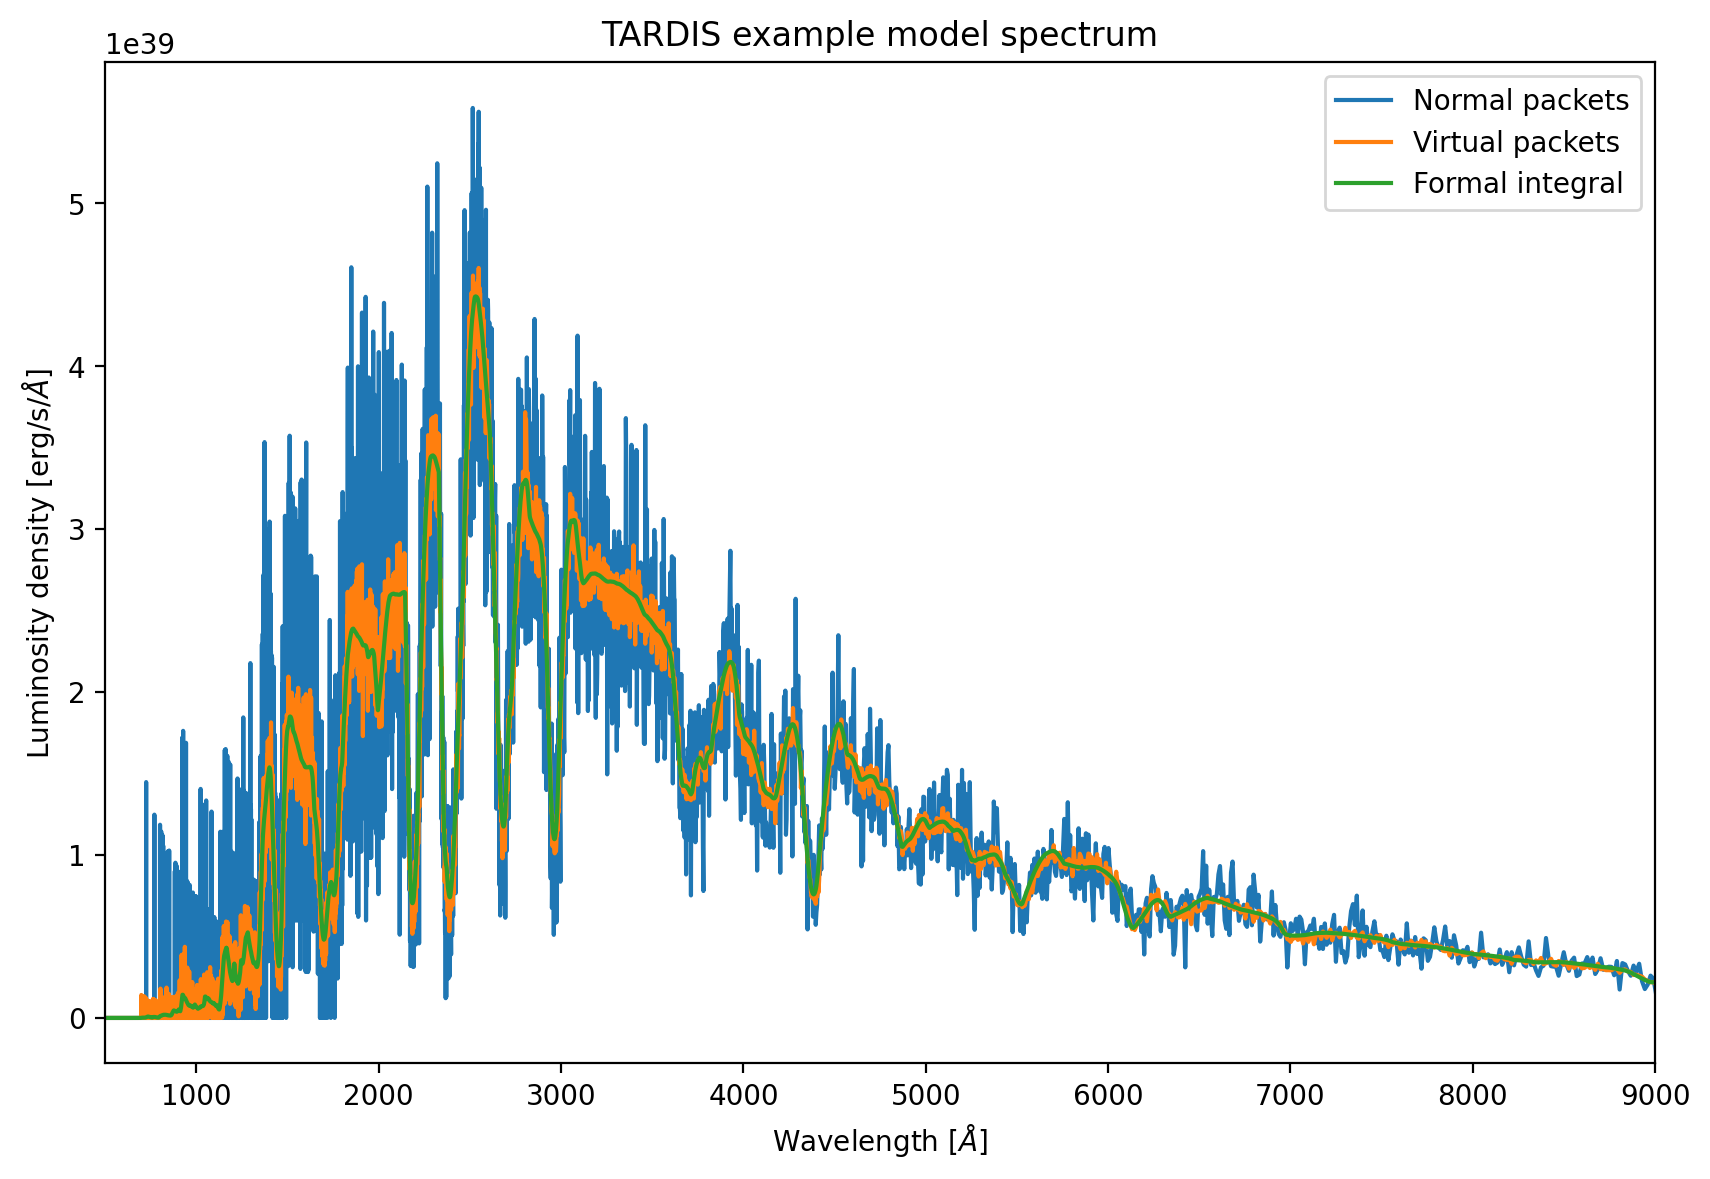

In [53]:
%matplotlib inline
plt.figure(figsize=(10, 6.5))

spectrum.plot(label="Normal packets")
spectrum_virtual.plot(label="Virtual packets")
spectrum_integrated.plot(label='Formal integral')

plt.xlim(500, 9000)
plt.title("TARDIS example model spectrum")
plt.xlabel("Wavelength [$\AA$]")
plt.ylabel("Luminosity density [erg/s/$\AA$]")
plt.legend()
plt.show()

In [54]:
from tardis.visualization import SDECPlotter

In [55]:
plotter = SDECPlotter.from_simulation(sim)

<Axes: xlabel='Wavelength $[\\mathrm{\\AA}]$', ylabel='$L_{\\lambda}$ [erg $\\mathrm{s^{-1}}$ $\\mathrm{\\AA^{-1}}$]'>

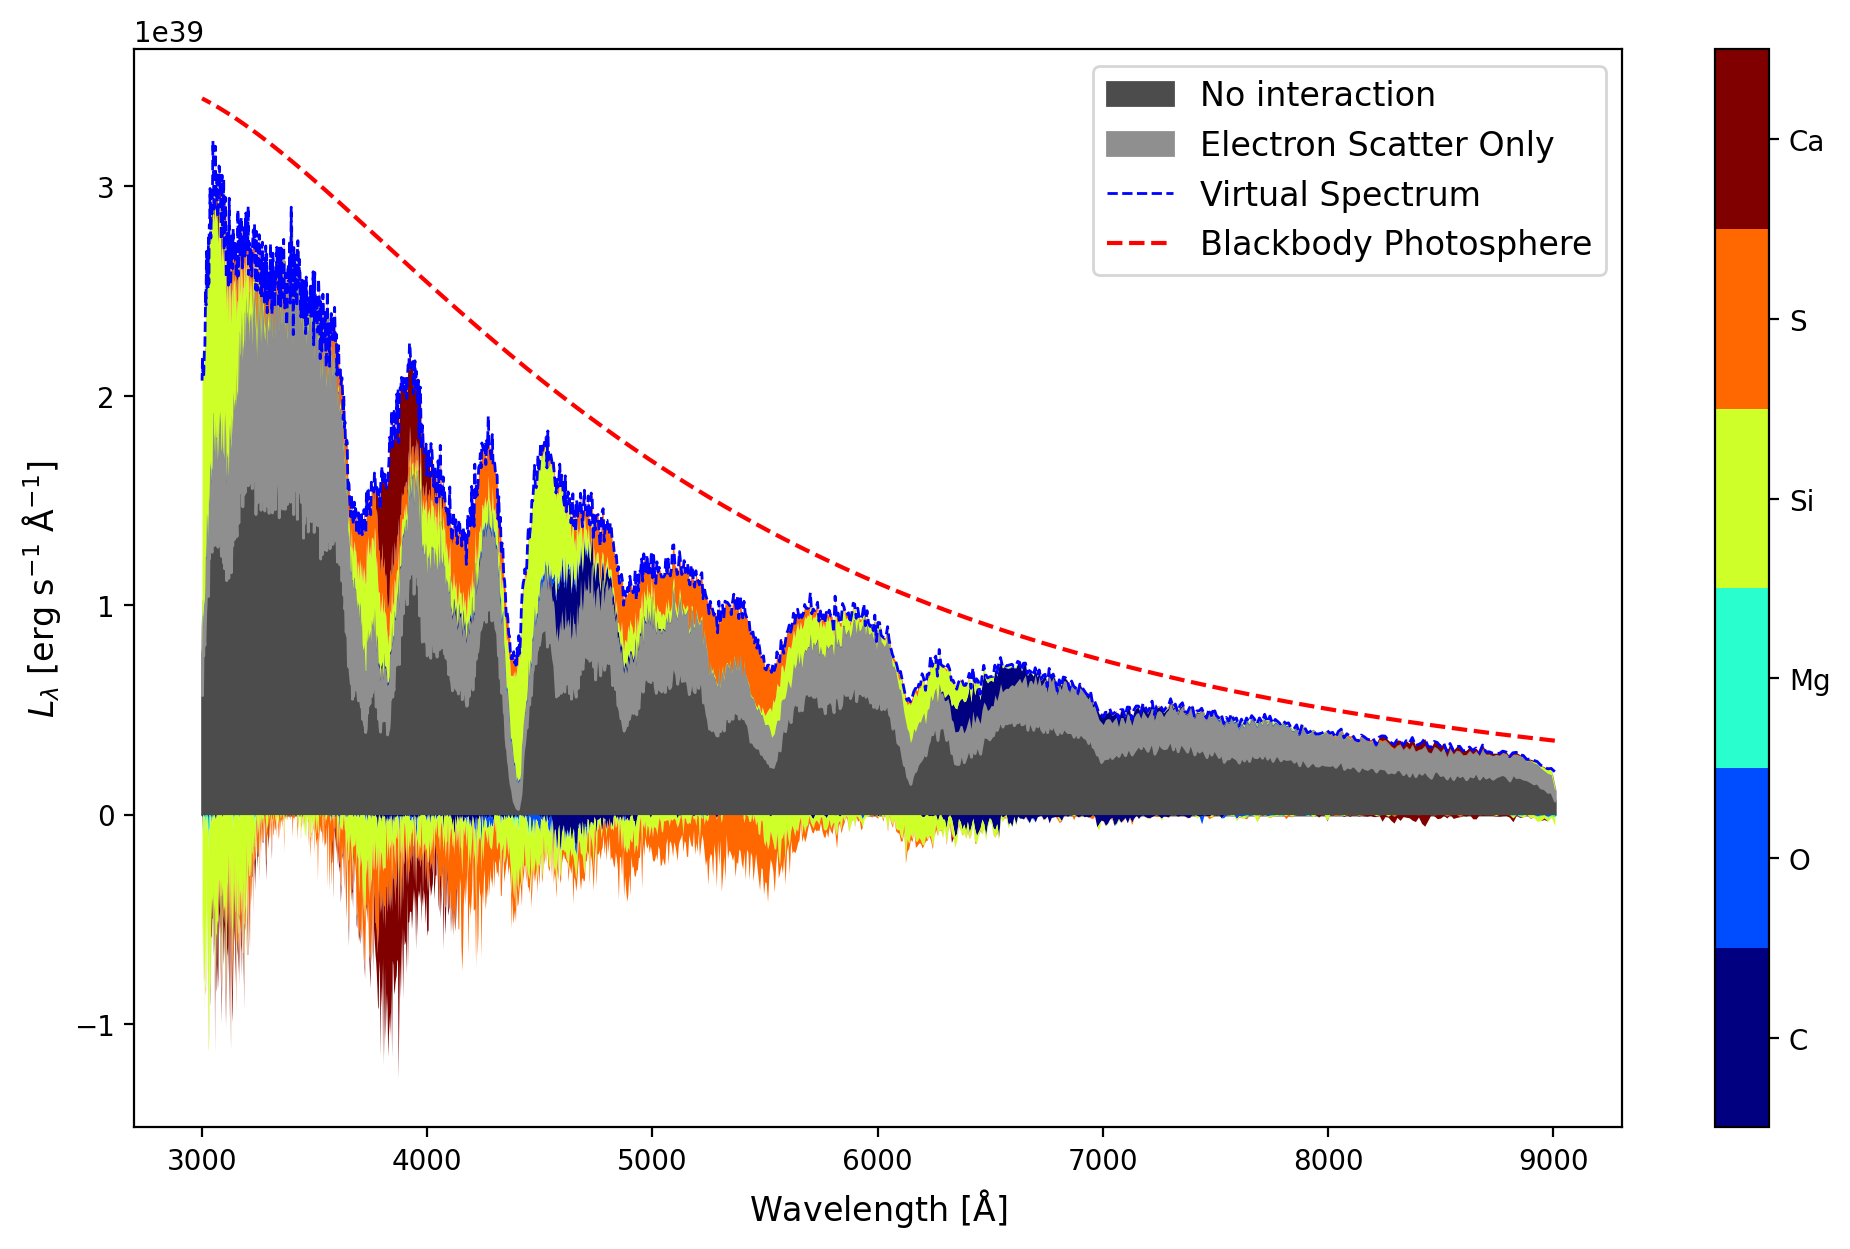

In [56]:
import astropy.units as u
plotter.generate_plot_mpl(packet_wvl_range=[3000, 9000] * u.AA)

<Axes: xlabel='Wavelength $[\\mathrm{\\AA}]$', ylabel='$L_{\\lambda}$ [erg $\\mathrm{s^{-1}}$ $\\mathrm{\\AA^{-1}}$]'>

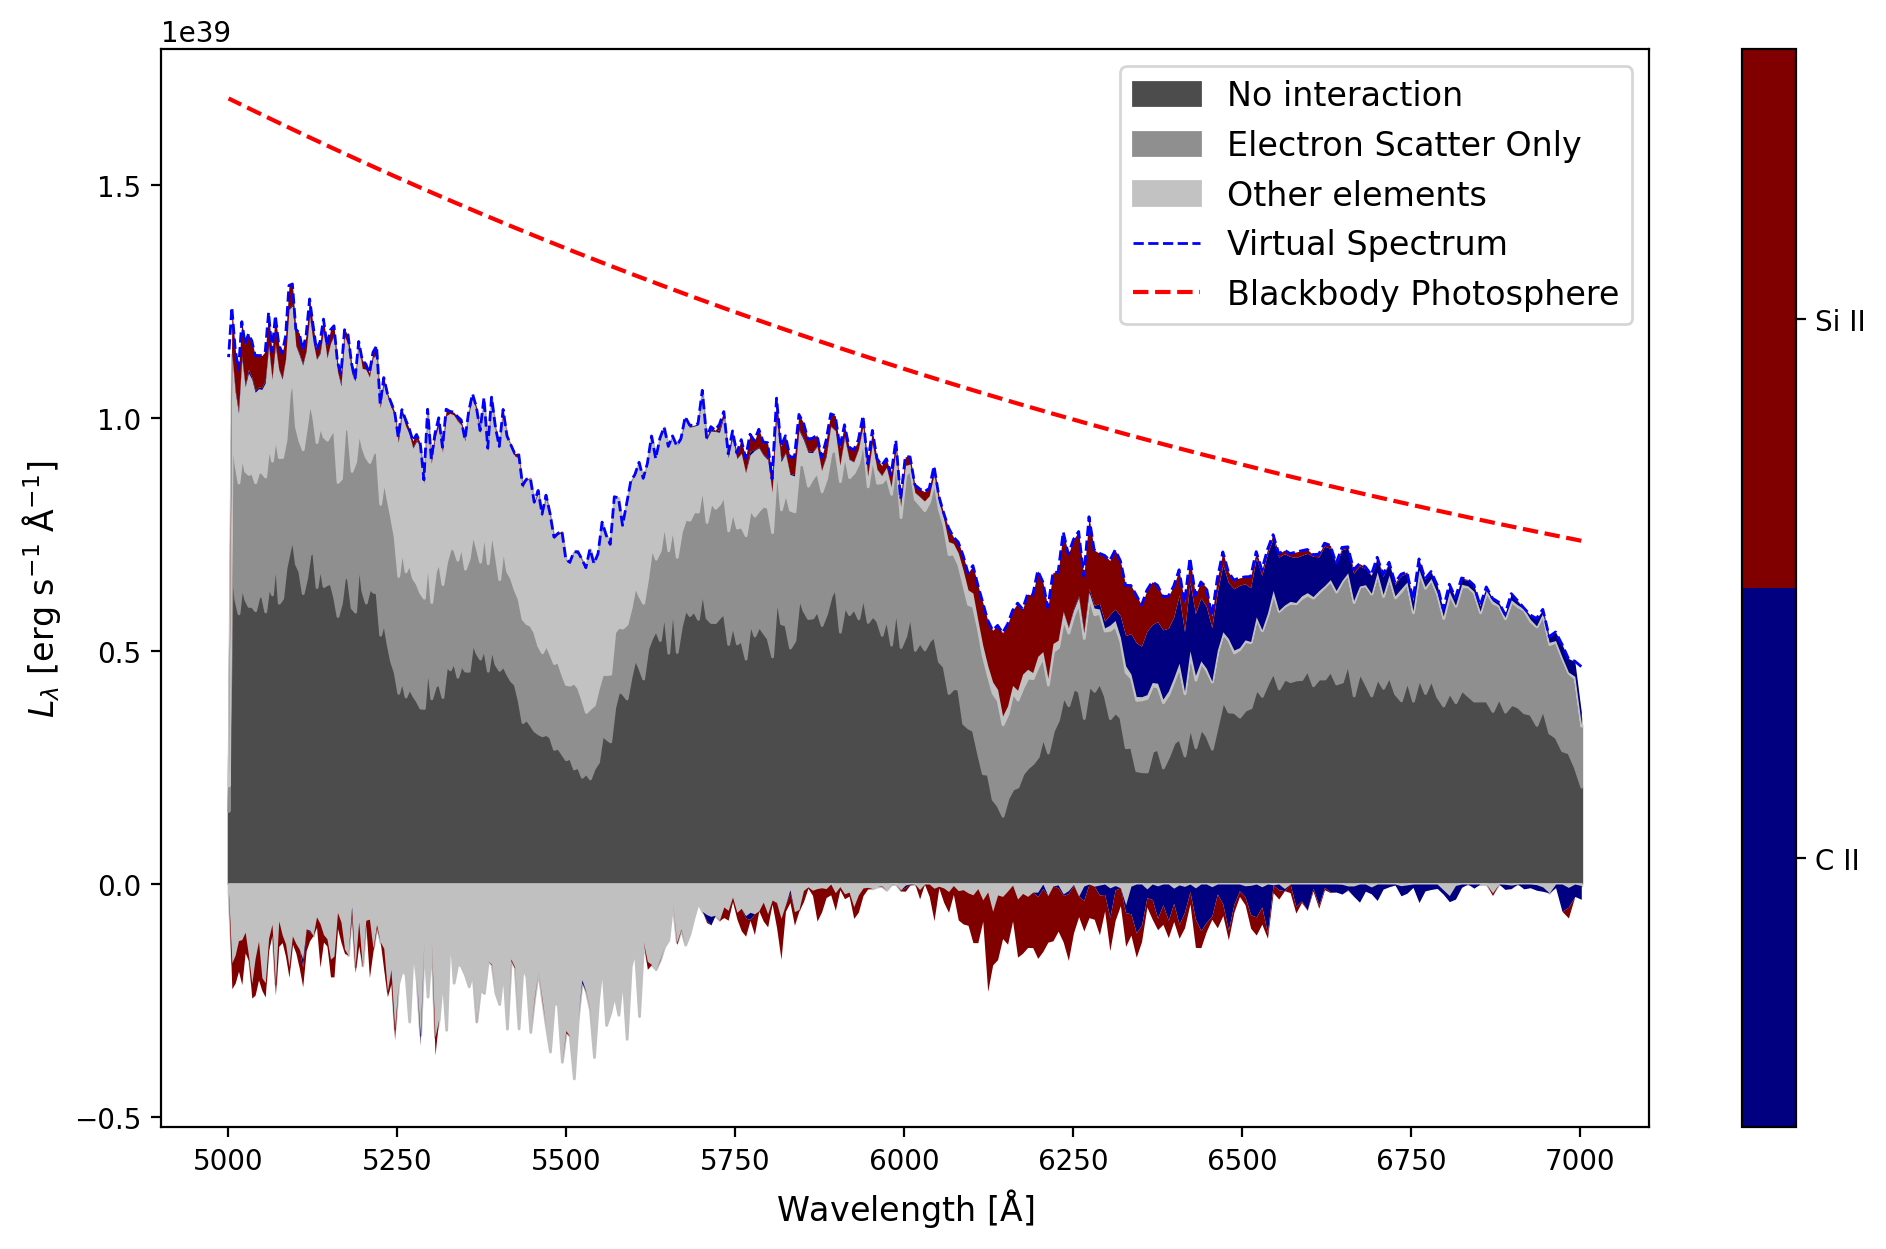

In [57]:
plotter.generate_plot_mpl(packet_wvl_range=[5000, 7000] * u.AA, species_list = ['Si II', 'C II'])

Do you see how C II and Si II are blended

Open the spectrum given in the folder and try to fit the spectrum

In [63]:
import pandas as pd
spectrum_file = pd.read_csv('sn_spectrum.dat', sep='\s+', names=['wavelength', 'flux'])
#plt.plot(spectrum_file['wavelength'], spectrum_file['flux'])

In [64]:
spectrum_file

,wavelength,flux
0,1279.60,3.706040e-16
1,1280.78,3.922030e-16
2,1281.96,4.059870e-16
3,1283.14,4.112570e-16
4,1284.32,4.083320e-16
...,...,...
2953,8433.75,1.311940e-15
2954,8435.95,1.487000e-15
2955,8438.17,1.571490e-15
2956,8440.36,1.481540e-15


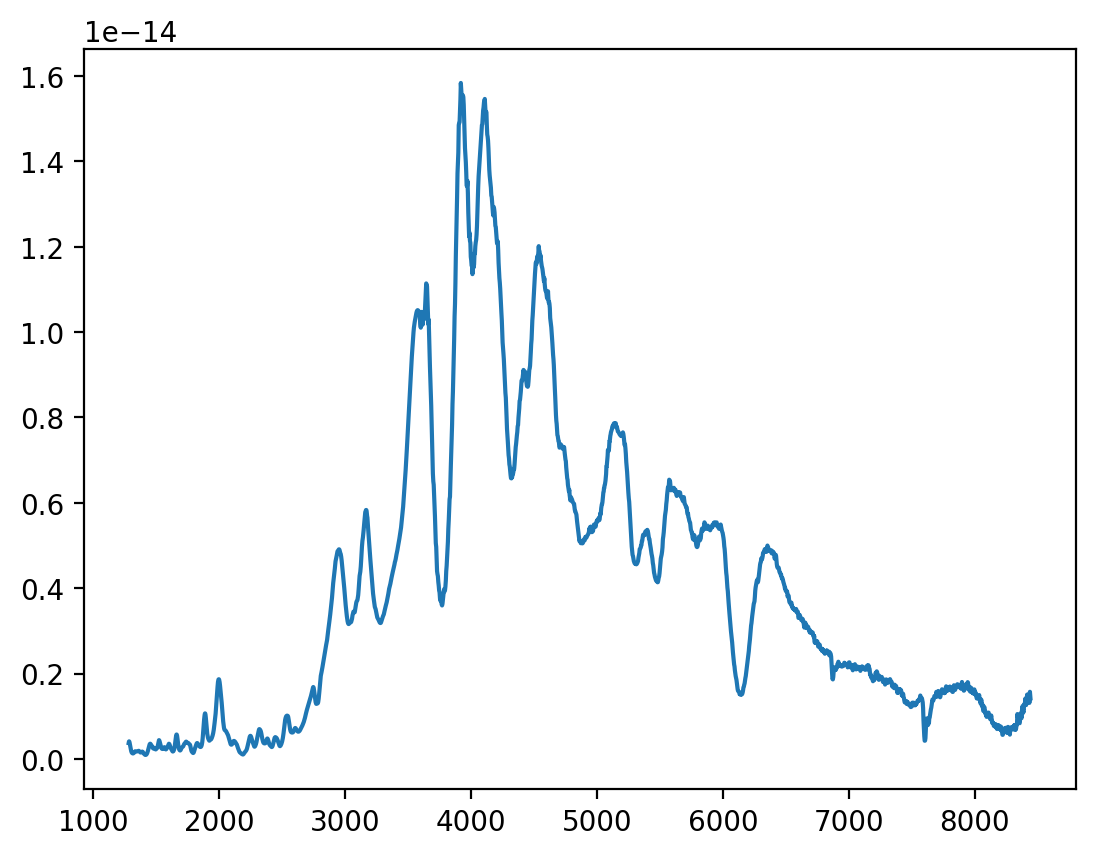

In [65]:
plt.plot(spectrum_file['wavelength'], spectrum_file['flux'])

1. Change the luminosity to match the continuum
2. Change the velocity start
3. Change the time since explosion

Chnage the flux to luminsity by assuming a distance modulus ~ 24.9 Mpc

In [66]:
def flux_to_luminosity(flux, distance):
    """
    Convert flux to luminosity using the formula:
    L = 4 * pi * d^2 * F
    where d is the distance in parsecs and F is the flux in erg/s/cm^2.
    """
    return 4 * np.pi * (distance * u.Mpc).to(u.cm)**2 * flux

In [67]:
# convert to lum
distance = 24.9
spectrum_file['luminosity'] = flux_to_luminosity(spectrum_file['flux'], distance)

In [68]:
spectrum_file

,wavelength,flux,luminosity
0,1279.60,3.706040e-16,2.749285e+37
1,1280.78,3.922030e-16,2.909515e+37
2,1281.96,4.059870e-16,3.011770e+37
3,1283.14,4.112570e-16,3.050865e+37
4,1284.32,4.083320e-16,3.029166e+37
...,...,...,...
2953,8433.75,1.311940e-15,9.732482e+37
2954,8435.95,1.487000e-15,1.103115e+38
2955,8438.17,1.571490e-15,1.165793e+38
2956,8440.36,1.481540e-15,1.099064e+38


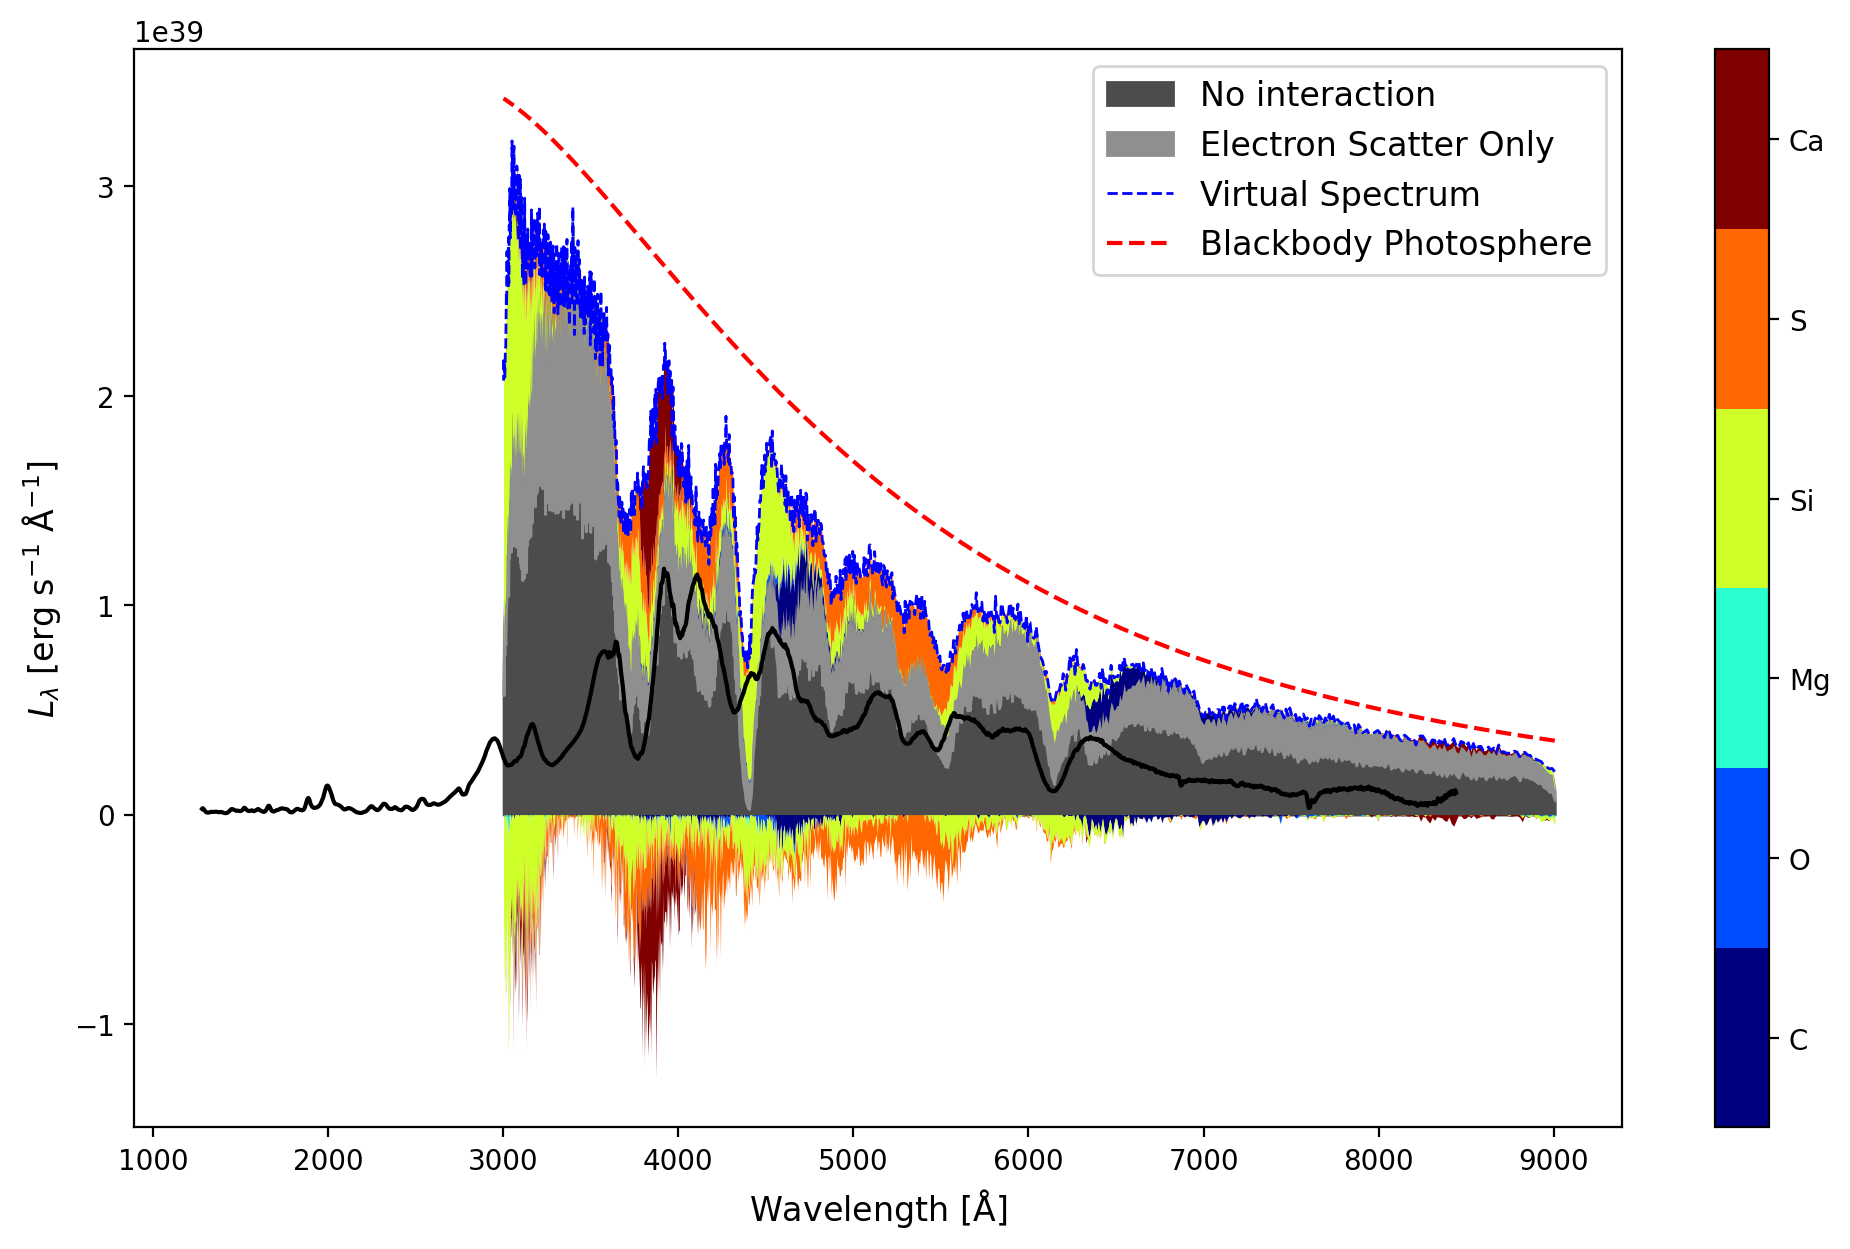

In [70]:
plotter.generate_plot_mpl(packet_wvl_range=[3000, 9000] * u.AA)
plt.plot(spectrum_file['wavelength'], spectrum_file['luminosity'], color='black')